In [36]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fetch data

In [4]:
def scrape_wikipedia_article(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_text = ''
    
    # Get the main content
    content_div = soup.find('div', {'id': 'mw-content-text'})
    if content_div:
        paragraphs = content_div.find_all('p')
        for p in paragraphs:
            article_text += p.get_text() + '\n\n'
    
    # Clean up the text
    article_text = article_text.replace('\n', ' ').replace('  ', ' ')
    return article_text

In [5]:
finance_urls = [
    "https://en.wikipedia.org/wiki/Finance",
    "https://en.wikipedia.org/wiki/Stock_market",
    "https://en.wikipedia.org/wiki/Investment_banking",
    "https://en.wikipedia.org/wiki/Hedge_fund",
    "https://en.wikipedia.org/wiki/Risk_management",
    "https://en.wikipedia.org/wiki/Corporate_finance",
    "https://en.wikipedia.org/wiki/Financial_economics",
    "https://en.wikipedia.org/wiki/Derivatives_(finance)"
]

In [6]:
documents = []
    
# Collect text from each URL
for url in finance_urls:
    article_title = url.split('/')[-1].replace('_', ' ')
    print(f"  Scraping: {article_title}")
    article_text = scrape_wikipedia_article(url)
    documents.append({"title": article_title, "text": article_text, "source": url})

# Create a DataFrame for easier handling
df = pd.DataFrame(documents)

  Scraping: Finance
  Scraping: Stock market
  Scraping: Investment banking
  Scraping: Hedge fund
  Scraping: Risk management
  Scraping: Corporate finance
  Scraping: Financial economics
  Scraping: Derivatives (finance)


In [9]:
print(df['text'][0])

  Finance refers to monetary resources and to the study and discipline of money, currency, assets and liabilities.[a] As a subject of study, it is related to but distinct from economics, which is the study of the production, distribution, and consumption of goods and services.[b] Based on the scope of financial activities in financial systems, the discipline can be divided into personal, corporate, and public finance.  In these financial systems, assets are bought, sold, or traded as financial instruments, such as currencies, loans, bonds, shares, stocks, options, futures, etc. Assets can also be banked, invested, and insured to maximize value and minimize loss. In practice, risks are always present in any financial action and entities.  Due to its wide scope, a broad range of subfields exists within finance. Asset-, money-, risk- and investment management aim to maximize value and minimize volatility. Financial analysis assesses the viability, stability, and profitability of an action

# Create vector space

In [10]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

# Process each document into chunks
all_chunks = []
for _, row in df.iterrows():
    chunks = text_splitter.split_text(row['text'])
    for chunk in chunks:
        all_chunks.append({
            "text": chunk,
            "source": row['source'],
            "title": row['title']
        })

print(f"  Created {len(all_chunks)} text chunks from {len(documents)} documents")

  Created 345 text chunks from 8 documents


In [12]:
all_chunks[0]

{'text': 'Finance refers to monetary resources and to the study and discipline of money, currency, assets and liabilities.[a] As a subject of study, it is related to but distinct from economics, which is the study of the production, distribution, and consumption of goods and services.[b] Based on the scope of financial activities in financial systems, the discipline can be divided into personal, corporate, and public finance.  In these financial systems, assets are bought, sold, or traded as financial instruments, such as currencies, loans, bonds, shares, stocks, options, futures, etc. Assets can also be banked, invested, and insured to maximize value and minimize loss. In practice, risks are always present in any financial action and entities.  Due to its wide scope, a broad range of subfields exists within finance. Asset-, money-, risk- and investment management aim to maximize value and minimize volatility. Financial analysis assesses the viability, stability, and profitability of a

In [ ]:
# Creating Embeddings and Vector Store
openai_api_temp_key = "API-key"
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_temp_key)

# Create a list of texts for embedding
texts = [chunk["text"] for chunk in all_chunks]
metadatas = [{"source": chunk["source"], "title": chunk["title"]} for chunk in all_chunks]

# Create the vector store
vector_store = FAISS.from_texts(texts=texts, embedding=embeddings, metadatas=metadatas)

In [21]:
vector_store

# Set up llm

In [39]:
# Set up the LLM
llm = OpenAI(temperature=0, openai_api_key=openai_api_temp_key)

# Create a custom prompt template
template = """You are a financial expert assistant. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context:
{context}

Question: {question}

Show your reasoning step by step before providing the final answer.
"""
QA_CHAIN_PROMPT = PromptTemplate(
    input_variables=["context", "question"],
    template=template,
)

# Create the retrieval chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 10}),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT},
    return_source_documents=True
)

# Real RAG

In [40]:
# ask a question about finance
finance_question = "What are the primary types of risk in financial markets and how do hedge funds manage them?"

# Get the retriever
retrieval_start = time.time()

retriever = qa_chain.retriever

# Get question embedding for similarity calculation
question_embedding = embeddings.embed_query(finance_question)

In [41]:
len(question_embedding)

1536

In [42]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    return dot_product / (norm_a * norm_b)

## Retrieve

In [43]:
# Get relevant documents
retrieved_docs = retriever.get_relevant_documents(query=finance_question)

# Get embeddings for each retrieved document
doc_embeddings = []
for doc in retrieved_docs:
    doc_embedding = embeddings.embed_query(doc.page_content)
    doc_embeddings.append(doc_embedding)

retrieval_end = time.time()
print(f"  Retrieved {len(retrieved_docs)} relevant documents in {retrieval_end - retrieval_start:.2f} seconds")

# Display retrieved content with similarity scores
print("\nRetrieved Content with Similarity Scores:")
for i, doc in enumerate(retrieved_docs):
    similarity = cosine_similarity(question_embedding, doc_embeddings[i])
    print(f"\nDocument {i+1} - Source: {doc.metadata['title']}")
    print(f"  Similarity Score: {similarity:.4f}")
    print(f"  Content: {doc.page_content[:150]}...")

  Retrieved 10 relevant documents in 6.73 seconds

Retrieved Content with Similarity Scores:

Document 1 - Source: Hedge fund
  Similarity Score: 0.8543
  Content: investment managers, and more prone to manager-specific idiosyncratic risks such as style drifts, faulty operations, or fraud.[86] New regulations int...

Document 2 - Source: Hedge fund
  Similarity Score: 0.8498
  Content: relatively uncorrelated with market indices and are consistent with investors' desired level of risk.[78][79] While hedging can reduce some risks of a...

Document 3 - Source: Finance
  Similarity Score: 0.8493
  Content: Additional to this diversification, the fundamental risk mitigant employed, investment managers will apply various hedging techniques as appropriate,[...

Document 4 - Source: Hedge fund
  Similarity Score: 0.8441
  Content: Hedge fund strategies are generally classified among four major categories: global macro, directional, event-driven, and relative value (arbitrage).[5...

Document 

In [44]:
len(doc_embeddings[0])

1536

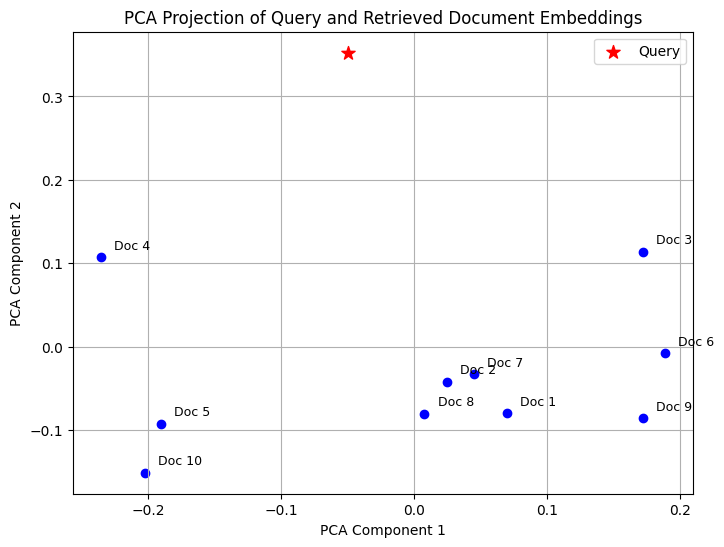

In [45]:
all_embeddings = [question_embedding] + doc_embeddings
all_embeddings = np.array(all_embeddings)

# Run PCA to reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[0, 0], reduced[0, 1], color='red', label='Query', s=100, marker='*')  # Query
for i in range(1, len(reduced)):
    plt.scatter(reduced[i, 0], reduced[i, 1], color='blue')
    plt.text(reduced[i, 0]+0.01, reduced[i, 1]+0.01, f'Doc {i}', fontsize=9)

plt.title("PCA Projection of Query and Retrieved Document Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Augmentation

In [46]:
# This is the simplified augmentation step by just concatenate related content together
augmented_context = "\n\n".join([doc.page_content for doc in retrieved_docs])

In [47]:
augmented_context

'investment managers, and more prone to manager-specific idiosyncratic risks such as style drifts, faulty operations, or fraud.[86] New regulations introduced in the US and the EU as of 2010 required hedge fund managers to report more information, leading to greater transparency.[87] In addition, investors, particularly institutional investors, are encouraging further developments in hedge fund risk management, both through internal practices and external regulatory requirements.[78] The increasing influence of institutional investors has led to greater transparency: hedge funds increasingly provide information to investors including valuation methodology, positions, and leverage exposure.[88]  Hedge funds share many of the same types of risk as other investment classes, including liquidity risk and manager risk.[86] Liquidity refers to the degree to which an asset can be bought and sold or converted to cash; similar to private-equity funds, hedge funds employ a lock-up period during\n

In [49]:
for i, doc in enumerate(retrieved_docs):
    print(f"\n{'='*20} Document {i+1} {'='*20}")
    print(doc.page_content.strip())


==================== Document 1 ====================
investment managers, and more prone to manager-specific idiosyncratic risks such as style drifts, faulty operations, or fraud.[86] New regulations introduced in the US and the EU as of 2010 required hedge fund managers to report more information, leading to greater transparency.[87] In addition, investors, particularly institutional investors, are encouraging further developments in hedge fund risk management, both through internal practices and external regulatory requirements.[78] The increasing influence of institutional investors has led to greater transparency: hedge funds increasingly provide information to investors including valuation methodology, positions, and leverage exposure.[88]  Hedge funds share many of the same types of risk as other investment classes, including liquidity risk and manager risk.[86] Liquidity refers to the degree to which an asset can be bought and sold or converted to cash; similar to private-equit

## Generation

In [48]:
generation_start = time.time()
    
# Generate the answer using the LLM and augmented context
result = qa_chain({"query": finance_question})
answer = result["result"]

generation_end = time.time()
overall_end = time.time()

print(f"  Answer generated in {generation_end - generation_start:.2f} seconds")

# Final Answer
print("\nFinal Answer:")
print(answer)

  Answer generated in 3.34 seconds

Final Answer:

Step 1: Identify the primary types of risk in financial markets.
The primary types of risk in financial markets include market risk, liquidity risk, operational risk, model risk, and concentration risk.

Step 2: Understand how hedge funds manage these risks.
Hedge funds manage these risks through various risk management strategies, such as diversification, hedging techniques, and risk monitoring. They also employ risk officers who assess and manage risks, and use different measurement techniques and models to estimate risk.

Step 3: Identify the specific risks that hedge funds face.
Hedge funds face market risk, which refers to the potential losses due to changes in market conditions. They also face liquidity risk, which refers to the degree to which an asset can be bought and sold or converted to cash. Operational risk, which includes risks such as style drifts, faulty operations, or fraud, is also a concern for hedge funds. Model ris